In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "BTC/USD" 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)
start = datetime(2021, 1, 1)
end = datetime.now().date() 

if not exists(SYM_HIST_FILE): # chacheing historical data  
    stk.save_historical_data(SYM_HIST_FILE, start, end)

price = stk.load_historical_data(SYM_HIST_FILE)
price.index = price.index.date 
price.head()

,symbol,open,high,low,close,volume,trade_count,vwap
2021-01-01,BTC/USD,29255.71,29682.29,28707.56,29676.79,848.874030,29639.0,29316.444625
2021-01-02,BTC/USD,29678.34,34200.00,29555.99,33769.52,2144.592516,60152.0,31941.412694
2021-01-03,BTC/USD,33769.52,34812.93,32300.61,32908.02,1838.695433,58725.0,33505.269474
2021-01-04,BTC/USD,32907.36,33496.03,27900.00,30441.57,2711.189503,69226.0,31267.965121
2021-01-05,BTC/USD,30461.84,35851.42,29927.55,35063.00,1756.751333,61880.0,33151.367357


<Axes: >

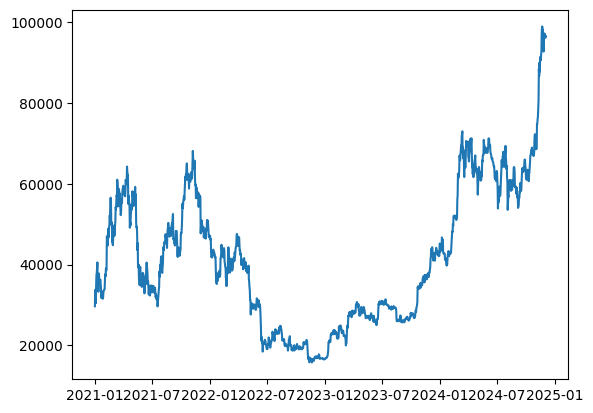

In [2]:
price["close"].plot()

In [3]:
price[SYMBOL] = price["close"]
price = price[SYMBOL].to_frame()
price.head()

,BTC/USD
2021-01-01,29676.79
2021-01-02,33769.52
2021-01-03,32908.02
2021-01-04,30441.57
2021-01-05,35063.00


<Axes: xlabel='timestamp'>

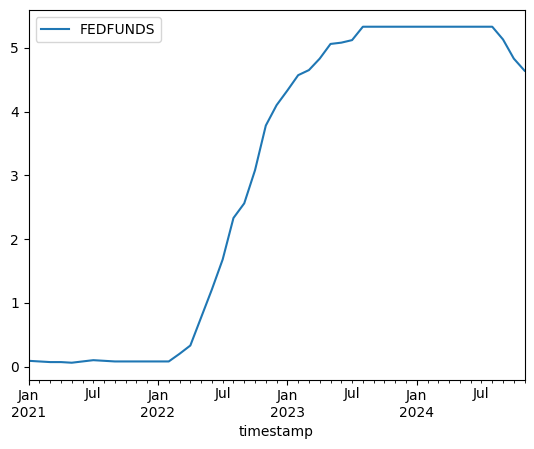

In [4]:
fed = pd.read_csv("./FEDFUNDS.csv")
fed["timestamp"] = pd.to_datetime(fed["DATE"])
fed.drop(columns=["DATE"], inplace=True)
fed.set_index(keys=["timestamp"], inplace=True)
fed = fed.loc[str(start):]
fed.head()
fed.plot()

<Axes: xlabel='timestamp'>

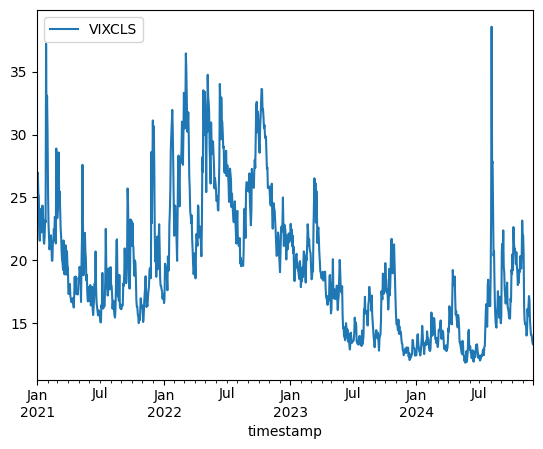

In [5]:
vix = pd.read_csv("./VIXCLS.csv")
vix["timestamp"] = pd.to_datetime(vix["DATE"])
vix.drop(columns=["DATE"], inplace=True)
vix.set_index(keys=["timestamp"], inplace=True)
vix = vix.replace(".",np.nan).astype(float).ffill()
vix = vix.loc[str(start):]
vix.head()
vix.plot()

<Axes: xlabel='timestamp'>

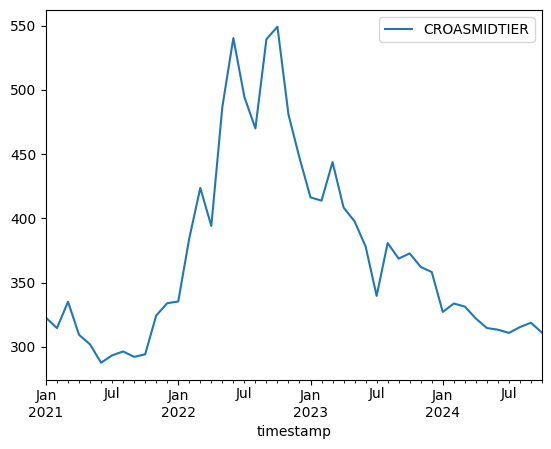

In [6]:
croa = pd.read_csv("./CROASMIDTIER.csv")
croa["timestamp"] = pd.to_datetime(croa["DATE"])
croa.drop(columns=["DATE"], inplace=True)
croa.set_index(keys=["timestamp"], inplace=True)
croa = croa.replace(".",np.nan).astype(float).ffill()
croa = croa.loc[str(start):]
croa.head()
croa.plot()

In [7]:
data = price.copy()
data = data.join(fed, how="outer").ffill()
data = data.join(vix, how="outer").ffill()
data = data.join(croa, how="outer").ffill()
data = data.bfill()
data.head()

,BTC/USD,FEDFUNDS,VIXCLS,CROASMIDTIER
2021-01-01,29676.79,0.09,22.75,322.581949
2021-01-02,33769.52,0.09,22.75,322.581949
2021-01-03,32908.02,0.09,22.75,322.581949
2021-01-04,30441.57,0.09,26.97,322.581949
2021-01-05,35063.00,0.09,25.34,322.581949


<Axes: >

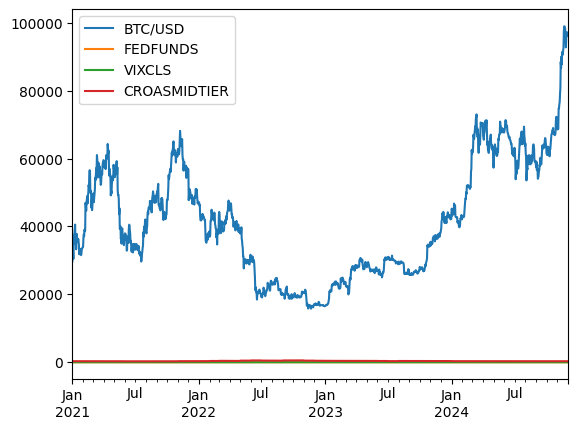

In [8]:
data.plot()

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data["price_scaled"] = scaler.fit_transform(data[[SYMBOL]])
data.head()

,BTC/USD,FEDFUNDS,VIXCLS,CROASMIDTIER,price_scaled
2021-01-01,29676.79,0.09,22.75,322.581949,-0.684659
2021-01-02,33769.52,0.09,22.75,322.581949,-0.447988
2021-01-03,32908.02,0.09,22.75,322.581949,-0.497806
2021-01-04,30441.57,0.09,26.97,322.581949,-0.640434
2021-01-05,35063.00,0.09,25.34,322.581949,-0.373190


In [10]:
#data["change"] = data[SYMBOL].shift(1).diff(10).fillna(0.0)
#data["signal"] = "non"
#data.loc[data["change"] > 10, "signal"] = "big++"
#data.loc[data["change"] < -10, "signal"] = "big--"
#data["change"].plot()
#data.drop(columns=["change"],inplace=True)

<Axes: >

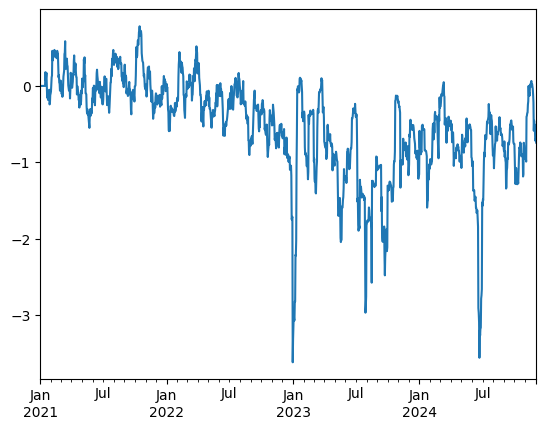

In [11]:
win_size = 15
df = data.copy()
df["daily_return"] = df[SYMBOL].pct_change()
df["risk_free_rate"] = df["FEDFUNDS"] / 252
df["excess_return"] = df["daily_return"] - df["risk_free_rate"]
sharpe_ratio = df["excess_return"].rolling(window=win_size).mean() / df["daily_return"].rolling(window=win_size).std()
sharpe_ratio = sharpe_ratio.fillna(0.0)
data["sharpe"] = sharpe_ratio
data["sharpe"].plot()

<Axes: >

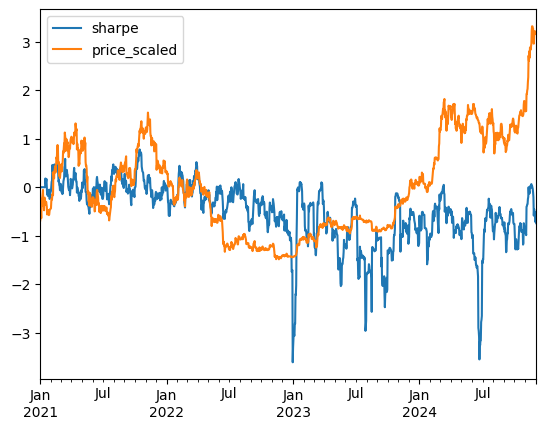

In [12]:

data[["sharpe","price_scaled"]].plot()

In [13]:
data["signal"] = "SELL"
data.loc[data["sharpe"] > 0, "signal"] = "BUY"
data.loc[data["sharpe"] < 0, "signal"] = "SELL"

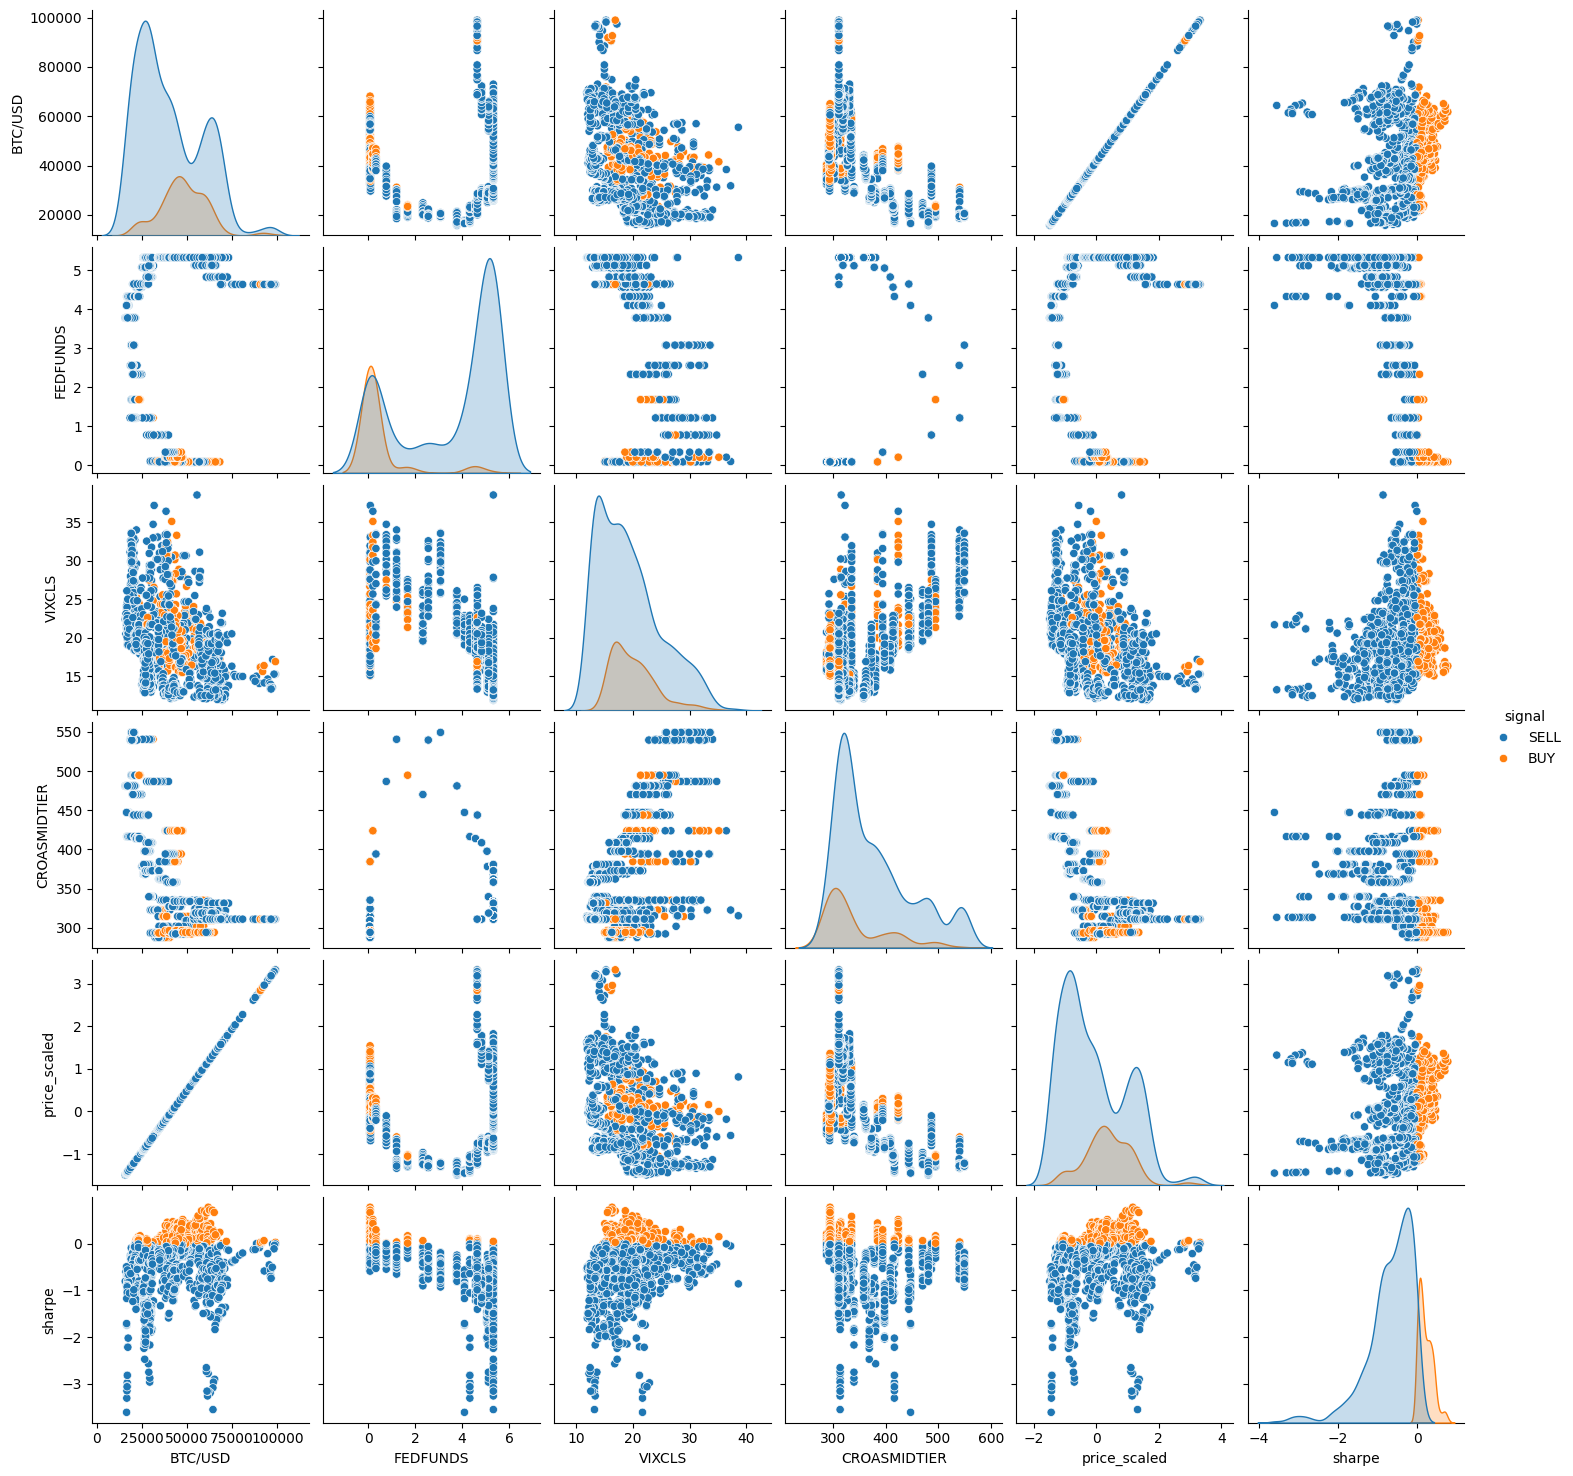

In [14]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#price[SYMBOL] = scaler.fit_transform(price[[SYMBOL]])
#price.head()
sns.pairplot(data, hue="signal")

In [15]:
df = data.copy()
df["daily_return"] = df[SYMBOL].pct_change()
df["risk_free_rate"] = df["FEDFUNDS"] / 252
df["excess_return"] = df["daily_return"] - df["risk_free_rate"]
sharpe_ratio = df["excess_return"].mean() / df["daily_return"].std()
sharpe_ratio

np.float64(-0.3156074325627579)